# Analyze A/B Test Results 
 
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

In [ ]:
# Read data

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape

(294478, 5)

In [4]:
df.user_id.nunique()

290584

In [5]:
df.converted.mean()

0.11965919355605512

In [6]:
df.query('group=="treatment" & landing_page=="old_page"').count()

user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
index1=df[(df['group']=="control")&(df['landing_page']=="new_page")].index
index2=df[(df['group']=="treatment")&(df['landing_page']=="old_page")].index

In [9]:
df1=df.drop(index1)

In [10]:
df2=df1.drop(index2)

In [11]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [12]:
df2.shape

(290585, 5)

In [13]:
df2.nunique()['user_id']

290584

In [14]:
df2[df2.duplicated(['user_id'])].user_id

2893    773192
Name: user_id, dtype: int64

In [15]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
# Remove one of the rows with a duplicate user_id..
df2=df2.drop_duplicates(subset='user_id')

In [17]:
df2.duplicated().sum()

0

In [18]:
df2.shape

(290584, 5)

In [19]:
df2.converted.mean()

0.11959708724499628

In [20]:
p_old=df2.query('group=="control"').converted.mean()
p_old

0.1203863045004612

In [21]:
p_new=df2.query('group=="treatment"').converted.mean()
p_new

0.11880806551510564

In [22]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff=p_new-p_old
obs_diff

-0.0015782389853555567

In [23]:
df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]

0.5000619442226688

>**Based on the data we have, convert rate of treatment group is less than control group, their is no evidence show that new treatment group users lead to more conversions.**

<a id='ab_test'></a>
## Part II - A/B Test


>**𝐻0: pnew - pold  <= 0      
>𝐻1: pnew - pold > 0**

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [24]:
p_new=df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [25]:
p_old=p_new
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? 

In [26]:
n_new=df2.query('landing_page=="new_page"').user_id.count()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [27]:
n_old=df2.query('landing_page=="old_page"').user_id.count()
n_old

145274

e. Simulate Sample for the `treatment` Group

In [28]:
# Simulate a Sample for the treatment Group

In [29]:
new_page_converted=np.random.choice([0,1],size=n_new,p=[(1-p_new),p_new])

f. Simulate Sample for the `control` Group

In [30]:
# Simulate a Sample for the control Group

In [31]:
old_page_converted=np.random.choice([0,1],size=n_old,p=[(1-p_old),p_old])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [32]:
p_diff=new_page_converted.mean()-old_page_converted.mean()


h. Sampling distribution

In [33]:
# Sampling distribution 
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs= new_converted_simulation - old_converted_simulation

In [34]:
p_diffs=np.array(p_diffs)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**. 

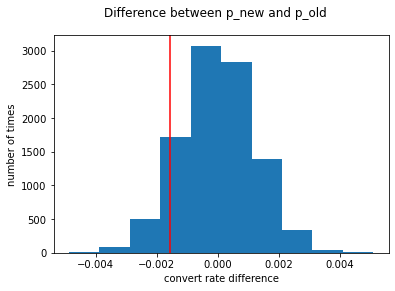

In [35]:
plt.hist(p_diffs)
plt.axvline(obs_diff,c='red')
plt.xlabel('convert rate difference')
plt.ylabel('number of times')
plt.suptitle("Difference between p_new and p_old")
plt.show()

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [36]:
(p_diffs>obs_diff).mean()

0.9034

**k.** Explain in words what you have just computed in part **j** above.  


>**(p_diffs>obs_diff).mean() is P value in scientific studies, usually we take the confidence interval of 95%, which means Type 1 error rate is 0.05, compare p value in this case with 0.05, (p_diffs>obs_diff).mean() is greater than 0.05, it means we failed to reject null hypothesis( pnew <= pold).**



**l. Using Built-in Methods for Hypothesis Testing**


In [37]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page=="old_page"').converted.sum()

# number of conversions with the new_page
convert_new = df2.query('landing_page=="new_page"').converted.sum()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page=="old_page"').user_id.count()

# number of individuals who received new_page
n_new = df2.query('landing_page=="new_page"').user_id.count()

**m.** Use `sm.stats.proportions_ztest()` to compute test statistic and p-value. 

In [38]:
count=np.array([convert_new,convert_old])
nobs=np.array([n_new,n_old])

In [39]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count,nobs,alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>**We should compare Z score with 𝑍𝛼, in this case, we take the confidence interval of 95%, which means we should compare Z score with 𝑍0.05. We know Z score is less than 𝑍0.05 from the caculation above, so we could say that we failed to reject null hypothesis. This finding matchs the finding in previous part.**

<a id='regression'></a>
### Part III - A regression approach


>**We can use logistic regression model since number in converted column just 0 and 1.**

In [40]:
df2['intercept']=1

In [41]:
page_dummies=pd.get_dummies(df2['landing_page'])

In [42]:
df2=df2.join(page_dummies)

In [43]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


In [44]:
df2=df2.rename(columns={"new_page":"ab_page"})

In [45]:
df2=df2.drop(['old_page'],axis=1)

In [46]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [47]:
logit_mod =sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [48]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-10-05 10:22 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

# **e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>**The p-value associated with ab_page is 0.1899. It's different from the p-value we calculated in the previous part. Beacuse the hypothesis for this two test are different. The null and alternative hypothesis are differenr from part 2. In this part, the null and alternative hypothesis are H0: pnew−pold=0; H1: pnew−pold≠0, it's a two-sided test. But in the previous part, the null and alternative hypothesis are  pnew−pold<=0; H1: pnew−pold>0, it's an right tailed test. That's why the p-value is different.**



In [49]:
# Read the countries.csv
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [50]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [51]:
# Create the necessary dummy variables
country_dummies=pd.get_dummies(df_new['country'])
df_new=df_new.join(country_dummies)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [52]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA','UK']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-10-05 10:22 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [53]:
np.exp(-0.0149),np.exp(-0.0408),np.exp(0.0099)

(0.9852104557227469, 0.9600211149716509, 1.0099491671175422)

>**From the summary data above, we know that:
1, converted is 0.98 times as likely on new page than old page,holding all other variables constant;
2, converted is 0.96 times on CA than US, holding all other variables constant;
3, converted is almost the same on UK and US, holding all other variables constant;
4, p-value of 'ab_page','CA','UK' are all greater than 0.05, so we can't reject the null hypothesis, it means we can't say 'ab_page', 'CA','UK' are statistically significant to predict whether an individual will be converted or not.** 

In [54]:
# Fit your model, and summarize the results

In [55]:
# add lower order terms
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']

In [56]:
df_new['ab_CA']=df_new['ab_page']*df_new['CA']

In [57]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,ab_UK,ab_CA
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [58]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA','UK','ab_CA','ab_UK']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-10-05 10:22 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_CA        -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
ab_UK         0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

Conclusions should include both statistical reasoning, and practical reasoning for the situation
1,Look at all of p-values in the summary, and compare against the Type I error rate (0.05).
2,Can you reject/fail to reject the null hypotheses (regression model)?
3,Comment on the effect of page and country to predict the conversion.


In [59]:
np.exp(-0.0206),np.exp(-0.0175),np.exp(-0.0057),np.exp(-0.0469),np.exp(0.0314)

(0.9796107305032505,
 0.9826522356650732,
 0.9943162141784332,
 0.9541828111007262,
 1.0318981806179213)

>**From the data above we could know that:
1, converted is 0.98 times on new page than old page;
2, converted is 0.98 times in CA than US;
3, converted is 0.99 times in UK than US;
4, converted is 0.95 times when an in dividual recieved new page in CA than recieved old page in US;
5, converted is 1.03 times when an in dividual recieved new page in UK than recieved old page in US;
6, all the p-value of 'ab_page','CA','UK','ab_CA','ab_UK' are greater than the Type I error rate (0.05), so we failed to reject the null hypothesis. That means we can't say that these variabels are statistically significant to predict whether an individual will converted or not.**


## Conclusion

>**From the A/B test part we failed to reject that pnew <= pold, and in regression part we know that all the page and country variables are not statistically significantly to predict an individual will convert or not. Eventhough the page and country variables can predict an individual will convert or not, the convert rate difference between new page and old page, US, CA and Uk is small, so our sugesstion is keep the old page.**

In [60]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1